In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)

import pickle
from pathlib import Path

from dlt.model import PDFmodel
from dlt.distribution import Distribution

In [ ]:
# Extension for the weights file
WEIGHTS_TOKEN = 'weights.h5'
def select_weight(epoch: int):
  return f"epoch_{int(epoch)}.{WEIGHTS_TOKEN}"

In [ ]:
# Path to the fit folder
FIT_FOLDER = Path('../Results/fits/fit_250417-01-L2-50000')

# Folder for the serialization
SERIALIZATION_FOLDER = FIT_FOLDER / 'serialization'
SERIALIZATION_FOLDER.mkdir(parents=True, exist_ok=True)

# Path to plot folder
PLOT_FOLDER = FIT_FOLDER / 'plots'
PLOT_FOLDER.mkdir(parents=True, exist_ok=True)

SAVE_PLOT = False
SAVE_NB = False
APPLY_LIM_KIN = False
ASSERT = True

In [ ]:
# Extract replicas from the fit folder
replicas_folders = [f for f in FIT_FOLDER.iterdir() if f.is_dir() and 'replica' in str(f)]
replicas_folders.sort()
replicas = len(replicas_folders)

# For each replicas, load the epochs and data
replica_epochs_dict = {}
for replica_folder in replicas_folders:
  epochs = [f for f in replica_folder.iterdir() if f.is_file() and WEIGHTS_TOKEN in str(f)]
  epochs.sort()
  replica_epochs_dict[replica_folder.name] = epochs

In [ ]:
# Find common epochs
# Different replicas may have different epochs, so we need to find the common ones
common_epochs = set()
for replica, epochs in replica_epochs_dict.items():
  aux = set()
  for epoch in epochs:
    epoch_num = int(epoch.name.split('.')[0].split('_')[1])
    aux.add(epoch_num)
  
  if len(common_epochs) == 0:
    common_epochs = aux
  else:
    common_epochs.intersection_update(aux)

common_epochs = sorted(list(common_epochs))
print(f"Common epochs: {common_epochs}")

Common epochs: [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000, 50001]


In [ ]:
from dlt import data
from pathlib import Path
import importlib.resources as pkg_resources

# Load Tommaso's file
data_path = Path(pkg_resources.files(data) / "BCDMS_data")
fk_grid = np.load(data_path / 'fk_grid.npy')
FK_original = np.load(data_path / 'FK.npy')
f_bcdms = np.load(data_path / 'f_bcdms.npy')
Cy = np.load(data_path / 'Cy.npy')

In [ ]:
# Extract the last common epoch from the ensemble of replicas
xT3_training = Distribution('xT3_training')
print(f'Loading {len(replicas_folders)} replicas...', end='\t')
for replica_path in replicas_folders:
    replica = replica_path.name
    last_epoch = replica_epochs_dict[replica][-1]

    model = PDFmodel.load_model(replica_path / 'config.json', last_epoch)
    xT3_training.add(model.predict().numpy().reshape(-1))
print('Done!')

# Compute T3 from xT3
T3_training = xT3_training.apply_operator(b=fk_grid, operator=lambda a, b: np.true_divide(a, b), axis=0, name=f'T3 at the end of the training')

In [ ]:
# Load the data used to fit the replicas
data_by_replica_original = Distribution("Original replicas of the data")

for rep in range(replicas):
  data = np.load(FIT_FOLDER / f'replica_{rep+1}' / 'data.npy')
  data_by_replica_original.add(data)

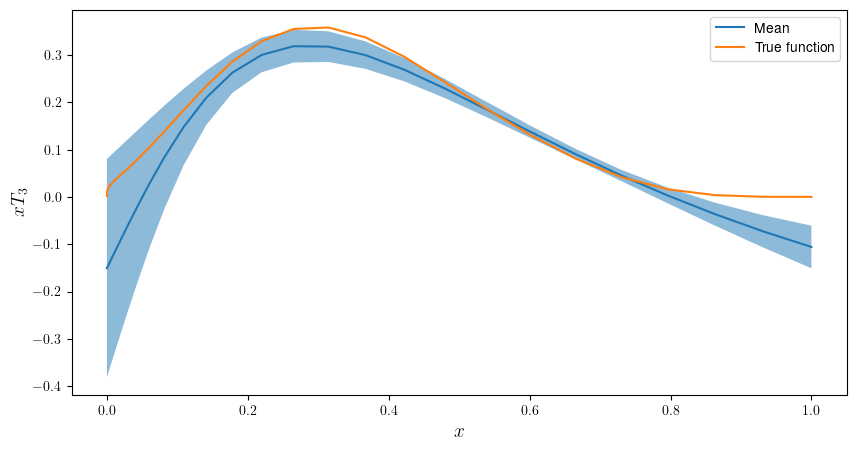

In [ ]:
# Plot the ensemble of xT3 at the end of the training
plt.figure(figsize=(10, 5))
plt.plot(fk_grid, xT3_training.get_mean(), label='Mean')
plt.fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)
plt.plot(fk_grid, f_bcdms, label='True function')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$xT_3$', fontsize=14)
plt.legend()
plt.show()
if SAVE_PLOT:
  plt.savefig(PLOT_FOLDER / 'pdf_mean_std.png', dpi=300)
plt.close()

In [ ]:
# Collect NTK statistics distributions for each replica over the training epochs
# This is the boilerplate code to compute the NTK and its statistics
if not any(SERIALIZATION_FOLDER.iterdir()):
  print('Data have not been serialized yet. Serializing now...')
  NTK_time = []
  frob_norm_time = []
  l2_norm_time = []
  linf_norm_time = []
  for epoch in common_epochs:
    print(f"Epoch {epoch} / {common_epochs[-1]}")
    NTK_distribution = Distribution(f'NTK epoch {epoch}') # Each epoch contains a distribution of NTKs
    frob_norm_dist = Distribution(f'Frobenius norm epoch {epoch}')
    l2_norm_dist = Distribution(f'L2 norm epoch {epoch}')
    linf_norm_dist = Distribution(f'Linf norm epoch {epoch}')
    for replica_path in replicas_folders:
      model = PDFmodel.load_model(replica_path / 'config.json', replica_path / select_weight(epoch))
      NTK = model.compute_ntk()
      _, S, _ = np.linalg.svd(NTK, hermitian=True)
      frob_norm_dist.add(np.sqrt(np.sum([s**2 for s in S])))
      l2_norm_dist.add(S[0])
      linf_norm_dist.add(np.linalg.norm(NTK, ord='inf'))
      NTK_distribution.add(NTK)

    NTK_time.append(NTK_distribution)
    frob_norm_time.append(frob_norm_dist)
    l2_norm_time.append(l2_norm_dist)
    linf_norm_time.append(linf_norm_dist)
    pickle.dump(NTK_time, open(SERIALIZATION_FOLDER / 'NTK_time.pickle', 'wb'))
    pickle.dump(frob_norm_time, open(SERIALIZATION_FOLDER / 'frob_norm_time.pickle', 'wb'))
    pickle.dump(l2_norm_time, open(SERIALIZATION_FOLDER / 'l2_norm_time.pickle', 'wb'))
    pickle.dump(linf_norm_time, open(SERIALIZATION_FOLDER / 'linf_norm_time.pickle', 'wb'))
else:
  print('Data have already been serialized. Loading from disk...')
  NTK_time = pickle.load(open(SERIALIZATION_FOLDER / 'NTK_time.pickle', 'rb'))
  frob_norm_time = pickle.load(open(SERIALIZATION_FOLDER / 'frob_norm_time.pickle', 'rb'))
  l2_norm_time = pickle.load(open(SERIALIZATION_FOLDER / 'l2_norm_time.pickle', 'rb'))
  linf_norm_time = pickle.load(open(SERIALIZATION_FOLDER / 'linf_norm_time.pickle', 'rb'))
  print('Done!')

Data have already been serialized. Loading from disk...
Done!


# Norm of the NTK over time

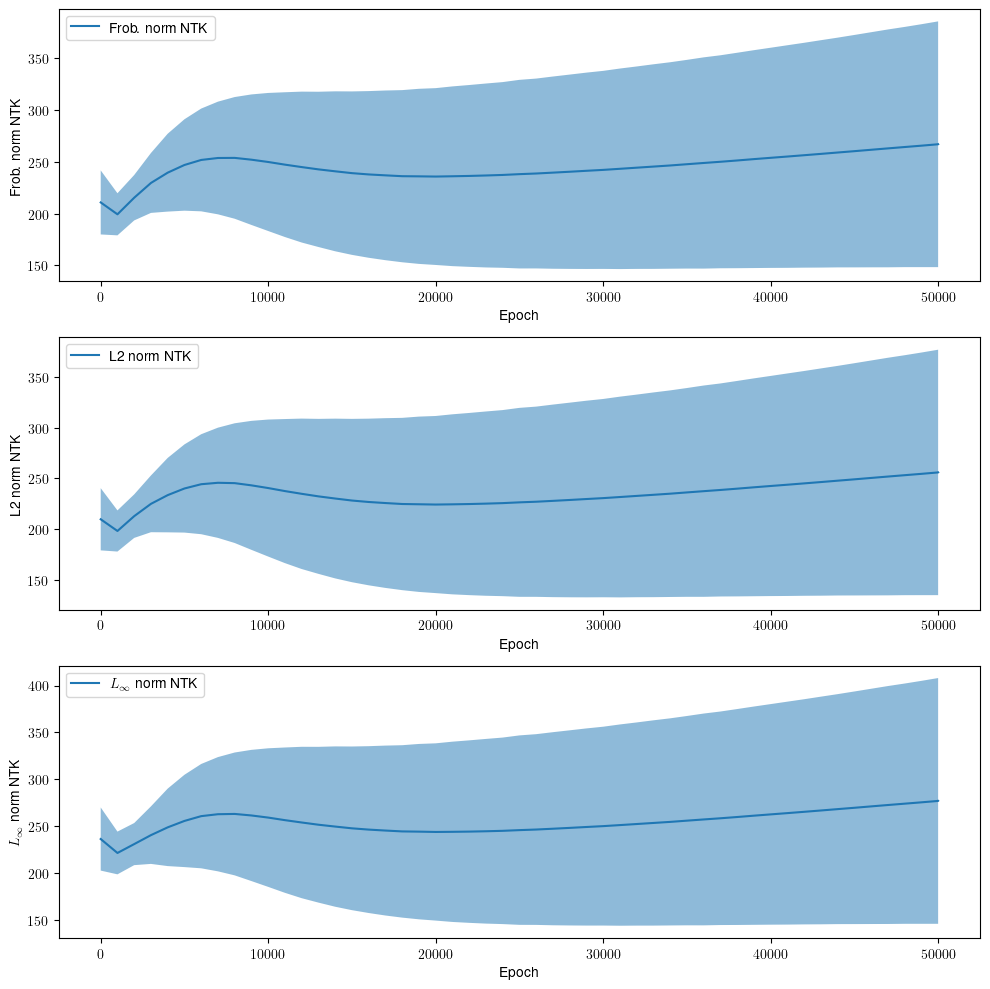

In [12]:
frob_means = np.array([frob.get_mean() for frob in frob_norm_time])
frob_stds = np.array([frob.get_std() for frob in frob_norm_time])
l2_means = np.array([l2.get_mean() for l2 in l2_norm_time])
l2_stds = np.array([l2.get_std() for l2 in l2_norm_time])
linf_means = np.array([linf.get_mean() for linf in linf_norm_time])
linf_stds = np.array([linf.get_std() for linf in linf_norm_time])

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].plot(common_epochs, frob_means, label='Frob. norm NTK')
axs[0].fill_between(common_epochs, frob_means + frob_stds, frob_means - frob_stds, alpha=0.5)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Frob. norm NTK')
axs[0].legend()

axs[1].plot(common_epochs, l2_means, label='L2 norm NTK')
axs[1].fill_between(common_epochs, l2_means + l2_stds, l2_means - l2_stds, alpha=0.5)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('L2 norm NTK')
axs[1].legend()

axs[2].plot(common_epochs, linf_means, label=r'$L_{\infty}$ norm NTK')
axs[2].fill_between(common_epochs, linf_means + linf_stds, linf_means - linf_stds, alpha=0.5)
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel(r'$L_{\infty}$ norm NTK')
axs[2].legend()

fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'NTK_norms.png', dpi=300)

# Change in the NTK over time

/var/folders/l5/l1kl3n_11gx3zm7b0wxctqym0000gn/T/ipykernel_34124/3573048809.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


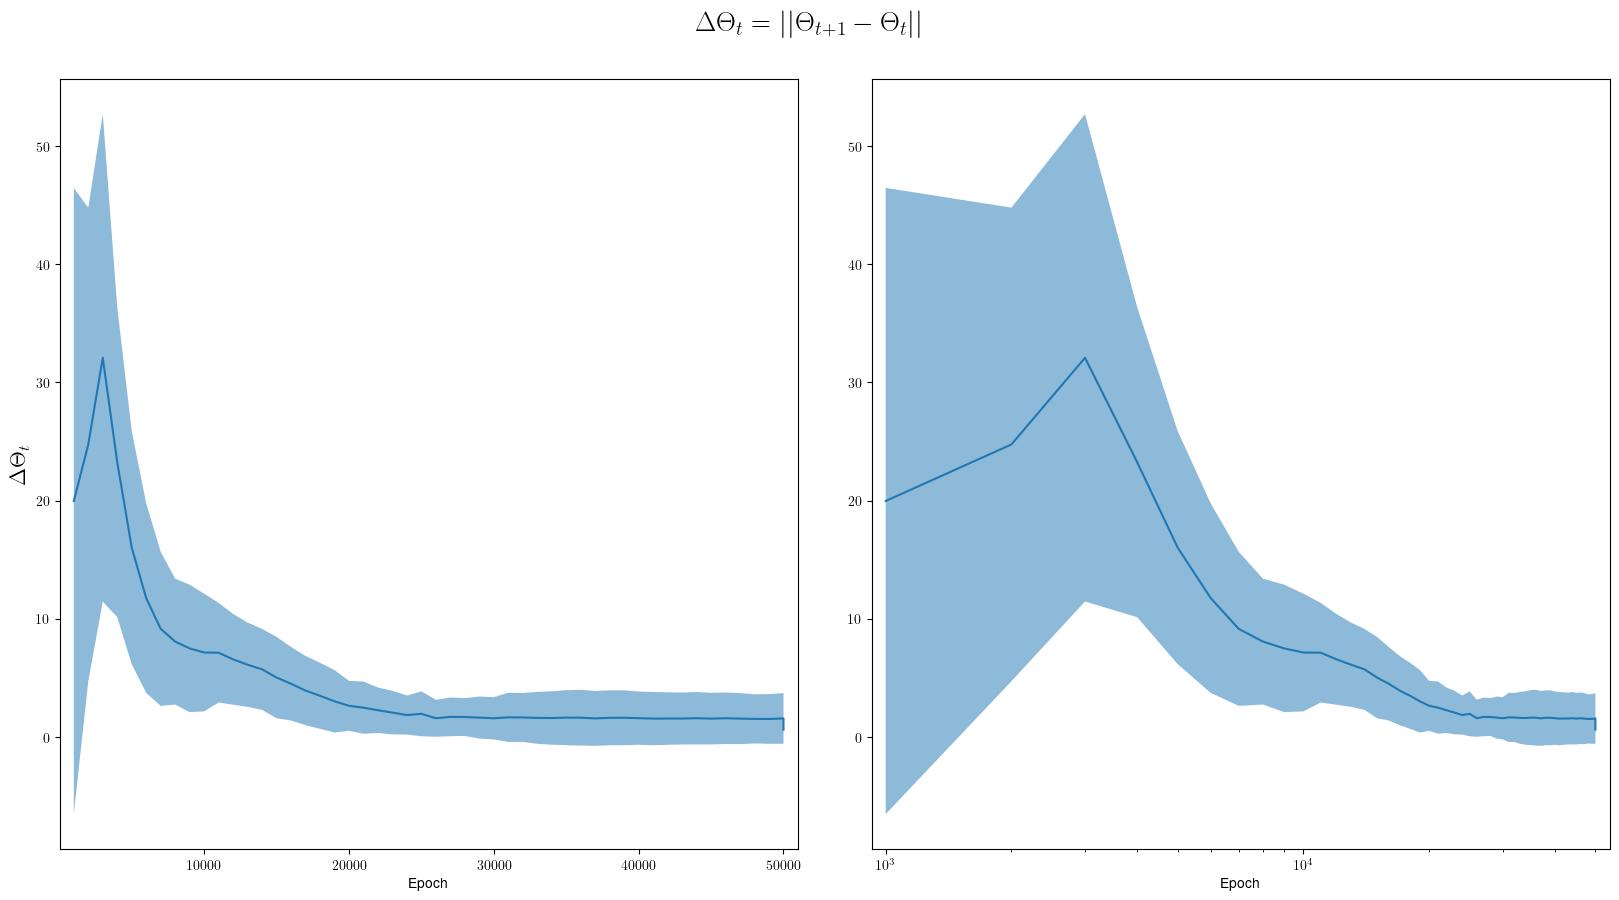

In [ ]:
# Compute  \Delta\Theta_t = || \Theta_{t+1} - \Theta_t}||
Delta_ntk_t = []
for i in range(len(NTK_time) - 1):
  delta_ntk_dist = Distribution(f'Delta NTK {i}')
  for rep in range(replicas):
    delta_ntk = np.linalg.norm(NTK_time[i + 1][rep] - NTK_time[i][rep])
    delta_ntk_dist.add(delta_ntk)
  Delta_ntk_t.append(delta_ntk_dist)

delta_ntk_means = np.array([delta.get_mean() for delta in Delta_ntk_t])
delta_ntk_stds = np.array([delta.get_std() for delta in Delta_ntk_t])

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

axs[0].plot(common_epochs[1:], delta_ntk_means, label='')
axs[0].fill_between(common_epochs[1:], delta_ntk_means + delta_ntk_stds, delta_ntk_means - delta_ntk_stds, alpha=0.5)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel(r'$\Delta \Theta_t$', fontsize=16)
axs[0].set_xmargin(0.02)

axs[1].plot(common_epochs[1:], delta_ntk_means, label='')
axs[1].fill_between(common_epochs[1:], delta_ntk_means + delta_ntk_stds, delta_ntk_means - delta_ntk_stds, alpha=0.5)
axs[1].set_xlabel('Epoch')
axs[1].set_xscale('log')
axs[1].set_xmargin(0.02)

fig.suptitle(r'$\Delta \Theta_t = || \Theta_{t+1} - \Theta_{t}||$', fontsize=20, y=0.95)
fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'delta_ntk.png', dpi=300)

# Model at initialisation

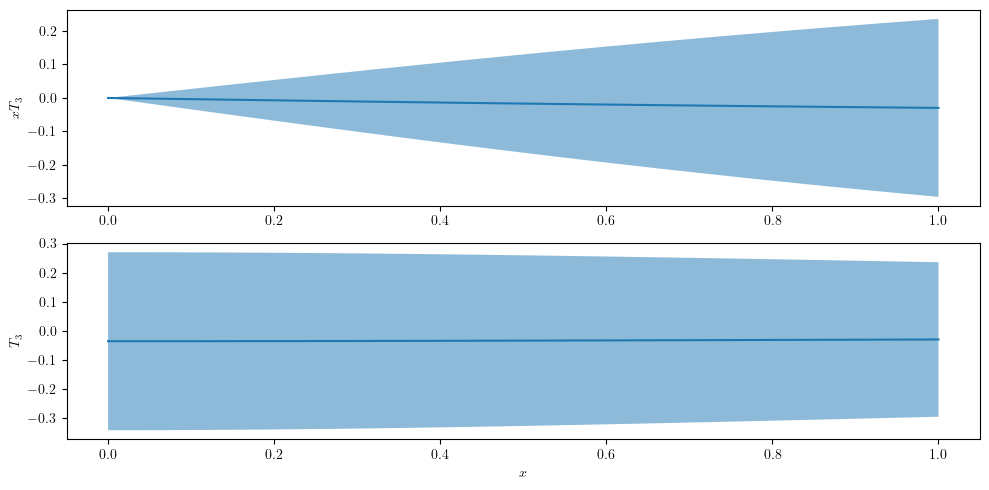

In [14]:
# Generating and ensemble of models
replicas = len(replicas_folders)
seed = 1423413
xT3_0 = Distribution('xT3 at initialisation')
T3_0 = Distribution('T3 at initialisation')
for rep in range(replicas):
  model = PDFmodel(
          dense_layer='Dense',
          input=fk_grid,
          outputs=1,
          architecture=[28,20],
          activations=['tanh', 'tanh'],
          kernel_initializer='GlorotNormal',
          user_ki_args=None,
          seed=seed + rep)

  xT3_0.add(model.predict().numpy().reshape(-1))
  T3_0.add(model.predict().numpy().reshape(-1) / fk_grid)


# Plot the distribution at initialisation
fig, axs = plt.subplots(2,1, figsize=(10, 5))
axs[0].plot(fk_grid, xT3_0.get_mean(), label='Mean')
axs[0].fill_between(fk_grid, xT3_0.get_mean()  - xT3_0.get_std(), xT3_0.get_mean() + xT3_0.get_std(), alpha=0.5)
axs[0].set_ylabel(r'$xT_3$')

axs[1].plot(fk_grid, T3_0.get_mean(), label='Mean')
axs[1].fill_between(fk_grid, T3_0.get_mean()  - T3_0.get_std(), T3_0.get_mean() + T3_0.get_std(), alpha=0.5)
axs[1].set_ylabel(r'$T_3$')
axs[1].set_xlabel(r'$x$')
#_ = plt.title('Distribution at initialisation')

fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'initialisation_distribution.png', dpi=300)